In [14]:
from sympy import *
from sympy.abc import a,b,c
init_session()
import numpy as np
%matplotlib inline
from sympy import var

# 輪郭線データその１
points = np.array([[115, 75], [106, 85],[99, 95],[95, 105],[94, 115],[92, 125],[92, 135],[93, 145],
 [96, 155],[104, 165],[115, 175],[129, 185], [151, 195],[171, 205],[181, 215],[184, 225],
 [185, 235],[185, 245],[184, 255],[183, 265],[182, 275],[181, 285],[179, 295],[177, 305]])
'''
# 輪郭線データその２
points = np.array([[159, 76],[164, 86], [174, 96], [182, 106], [189, 116],
 [193, 126], [198, 136], [201, 146], [204, 156], [206, 166], [207, 176], [206, 186], [205, 196],
 [204, 206], [202, 216], [200, 226], [198, 236], [194, 246], [191, 256], [189, 266], [189, 276],
 [189, 286], [189, 296]])''';

IPython console for SymPy 1.2 (Python 3.6.6-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



In [15]:
# ベジエフィッティング
def fitBezierCurve3(points,precPara=0.01,mode=2):
    # mode = 2：両端固定、　mode =3 : 下のみ固定, mode4 :  全制御点自由
    # ベジエ曲線を定義するのに使うシンボルの宣言
    P = [Symbol('P' + str(i)) for i in range(4)]
    px,py =var('px:4'),var('py:4')
    for i in range(4):
        P[i] = Matrix([px[i],py[i]]) 
    t = symbols("t")
    
    # いわゆる自乗誤差の一般式
    s,t= symbols('s,t')
    loss1 = (s - t)**2
    # 最小自乗法の目的関数の一般式
    def lossfunc(listA,listB):
        return sum([loss1.subs([(s,a),(t,b)]) for (a,b) in zip(listA,listB)])/2
    
    # ３次のベジエ曲線の定義式制御点 P0~P3 とパラメータ　　t　の関数として定義
    bez3 = (1-t)**3*P[0] + 3*(1-t)**2*t*P[1] + 3*(1-t)*t**2*P[2] + t**3*P[3]
    
    # 初期の推定パラメータの決定
    ## サンプル点間の差分を求める
    points1 = points[1:] #  ２つ目から後ろのサンプル点
    ds = points1-points[:-1] # サンプル点間の差分ベクトル
    la = [np.sqrt(e[0]*e[0]+e[1]*e[1]) for e in ds] # サンプル点間の直線距離のリスト
    axlength = np.sum(la) # 折れ線近似による経路長
    tpara0 = np.zeros(len(points),np.float32) # パラメータ格納配列
    tpara = tpara0.copy()
    tpara[0]=0.0 # 最初の点のパラメータ推定値は０とする
    for i in range(len(la)):
        tpara[i+1] = tpara[i]+la[i] # 各サンプル点での積算経路長
    tpara = tpara/axlength # 全経路長で割ってパラメータとする　（０〜１）

    #  パラメトリック曲線　linefunc 上で各サンプル点に最寄りの点のパラメータを対応づける
    def refineTpara(pl,linefunc):
        (funcX,funcY) = linefunc # funcX,funcY は t の関数
        # 各サンプル点に最も近い曲線上の点のパラメータ t を求める。
        trange = np.arange(-0.1,1.1,0.01) # 推定範囲は -0.1 〜　１．１
        onpoints = [[s,funcX.subs(t,s),funcY.subs(t,s)] for s in trange] # 曲線上の点
        tpara = np.zeros(len(pl),np.float32) # 新しい 推定 t パラメータのリスト用の変数のアロケート
        refineTparaR(pl,tpara,0,len(pl),0,len(onpoints),onpoints)
        return tpara

    # 範囲全体をサーチするのはかなり無駄なので、約６割ぐらいに狭める
    def srange(n,stt,end,smin,smax):
        if end - stt < 3 : # 残り３点未満なら全域サーチする
            left,right = smin,smax
        else:
            left = smin+0.5*(smax-smin)*(n-stt)/(end-stt-1)
            right= smax - 0.5*(smax-smin)*(end-n-1)/(end-stt-1)
        left = (int(left-0.5)   if int(left-0.5) > smin else smin)
        right = (int(right+0.5) if int(right+0.5) < smax else smax)
        return left, right
        
    #  探索範囲内での対応づけ再帰関数
    # pl 点列、(stt,end) 推定対象範囲（番号）, (smin,smax) パラメータの探索範囲         
    def refineTparaR(pl,tpara,stt,end,smin,smax,onpoints):
        if stt >end:
            return 
        else:
            nmid = int((end+stt)/2) # 探索対象の中央のデータを抜き出す
            px,py = points[nmid] # 中央のデータの座標
            smin1, smax1 = srange(nmid,stt,end,smin,smax)
            differ = onpoints[smin1:smax1].copy() 
            differ = differ - np.array([0.0,px,py]) # 差分の配列
            distance = [x*x+y*y for _t,x,y in differ] # 自乗誤差の配列
            nearest_i = smin1+np.argmin(distance) # 誤差最小のインデックス
            tpara[nmid] = onpoints[nearest_i][0] # 中央点のパラメータが決定
            if nmid-stt >= 1 : # 左にまだ未処理の点があるなら処理する
                refineTparaR(pl,tpara, stt,nmid,smin,nearest_i,onpoints)
            if end-(nmid+1) >=1 : # 右にまだ未処理の点があるなら処理する
                refineTparaR(pl,tpara,nmid+1,end,nearest_i+1,smax,onpoints) 
                
    while True:
        linepoints = [bez3.subs(t,t_) for t_ in tpara] # 曲線上の点列
        linepointsX = [x  for  [x,y] in linepoints] # X
        linepointsY = [y  for  [x,y] in linepoints] # Y
        EsumX = lossfunc(listA=points[:,0],listB=linepointsX) #  X方向のずれの評価値
        EsumY = lossfunc(listA=points[:,1],listB=linepointsY) #  Y 方向のずれの評価値
        # px0,px1, px2, px3, py1, py2,py3,py4 で偏微分
        if  mode<4:
            # P3は固定なので座標を代入
            EsumX = EsumX.subs(px[3],points[-1][0])
            EsumY = EsumY.subs(py[3],points[-1][1])
        if mode<3:
            # P0も固定なので座標を代入
            EsumX = EsumX.subs(px[0],points[0][0])
            EsumY = EsumY.subs(py[0],points[0][1])
        dx_1 = diff(EsumX,px1)
        dx_2 = diff(EsumX,px2)
        dy_1 = diff(EsumY,py1)
        dy_2 = diff(EsumY,py2)
        if mode>2:
            dx_0 = diff(EsumX,px0)
            dy_0 = diff(EsumY,py0)
        if mode>3:
            dx_3 = diff(EsumX,px3)
            dy_3 = diff(EsumY,py3)

        # 連立させて解く
        if mode == 4:
            resultX = solve([dx_0,dx_1,dx_2,dx_3],[px[0],px[1],px[2],px[3]])
            resultY = solve([dy_0,dy_1,dy_2,dy_3],[py[0],py[1],py[2],py[3]])
        elif mode ==3:
            resultX = solve([dx_0,dx_1,dx_2],[px[0],px[1],px[2]])
            resultY = solve([dy_0,dy_1,dy_2],[py[0],py[1],py[2]])
        else : # mode ==2
            resultX = solve([dx_1,dx_2],[px[1],px[2]])
            resultY = solve([dy_1,dy_2],[py[1],py[2]])
            
        # 解をベジエの式に代入
        if mode == 4:
            bezresX = bez3[0].subs([(px[0],resultX[px0]),(px[1],resultX[px1]),(px[2],resultX[px2]),(px[3],resultX[px3])])
            bezresY = bez3[1].subs([(py[0],resultY[py0]),(py[1],resultY[py1]),(py[2],resultY[py2]),(py[3],resultY[py3])])
        elif mode == 3:
            bezresX = bez3[0].subs([(px[0],resultX[px0]),(px[1],resultX[px1]),(px[2],resultX[px2]),(px[3],points[-1][0])])
            bezresY = bez3[1].subs([(py[0],resultY[py0]),(py[1],resultY[py1]),(py[2],resultY[py2]),(py[3],points[-1][1])])
        else : # mode ==2
            bezresX = bez3[0].subs([(px[0],points[0][0]),(px[1],resultX[px1]),(px[2],resultX[px2]),(px[3],points[-1][0])])
            bezresY = bez3[1].subs([(py[0],points[0][1]),(py[1],resultY[py1]),(py[2],resultY[py2]),(py[3],points[-1][1])])
            
        rx,ry = resultX,resultY
        if mode == 4:
            cpx = [rx[px0],rx[px1],rx[px2],rx[px3]]
            cpy = [ry[py0],ry[py1],ry[py2],ry[py3]]
        elif mode == 3:
            cpx = [rx[px0],rx[px1],rx[px2],points[-1][0]]
            cpy = [ry[py0],ry[py1],ry[py2],points[-1][1]]
        else: # mode==2
            cpx = [points[0][0],rx[px1],rx[px2],points[-1][0]]
            cpy = [points[0][1],rx[px1],ry[py2],points[-1][1]]
            
        tpara0 = tpara.copy()
        tpara = refineTpara(points,(bezresX,bezresY))
        diffpara = 0
        for i in range(len(tpara)) :
            diffpara += np.sqrt((tpara[i]-tpara0[i])**2)
        print("diffpara",diffpara)
        if diffpara < precPara:
            break
        
    return cpx,cpy,bezresX,bezresY
        

# 輪郭と軸のサンプルデータ　　data  を３本のベジエ曲線で近似する
def fitBezierAndDraw(data,mode=2):
    datal,datac,datar = data[:,0],data[:,1],data[:,2]
    # 初期の推定パラメータの決定
    cpxl,cpyl,bezXl,bezYl = fitBezierCurve3(points=datal,precPara=0.01,mode=mode)
    cpxc,cpyc,bezXc,bezYc = fitBezierCurve3(points=datac,precPara=0.01,mode=mode)
    cpxr,cpyr,bezXr,bezYr = fitBezierCurve3(points=datar,precPara=0.01,mode=mode)

    # 結果の描画
    plt.figure(figsize=(7,10),dpi=100)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(np.array(datal)[:,0],np.array(datal)[:,1])
    plt.scatter(np.array(datac)[:,0],np.array(datac)[:,1])
    plt.scatter(np.array(datar)[:,0],np.array(datar)[:,1])
    tplins = np.linspace(-0.02, 1.02,50)
    plotx = [bezXl.subs(t,tp) for tp in tplins ]
    ploty = [bezYl.subs(t,tp) for tp in tplins ]
    plt.scatter(cpxl,cpyl)
    plt.plot(plotx,ploty)
    tplins = np.linspace(0, 1,50)
    plotx = [bezXl.subs(t,tp) for tp in tplins ]
    ploty = [bezYl.subs(t,tp) for tp in tplins ]
    plt.plot(plotx,ploty,color='red')  
    tplins = np.linspace(-0.02, 1.02,50)
    plotx = [bezXc.subs(t,tp) for tp in tplins ]
    ploty = [bezYc.subs(t,tp) for tp in tplins ]
    plt.scatter(cpxc,cpyc)
    plt.plot(plotx,ploty)
    tplins = np.linspace(0, 1,50)
    plotx = [bezXc.subs(t,tp) for tp in tplins ]
    ploty = [bezYc.subs(t,tp) for tp in tplins ]
    plt.plot(plotx,ploty,color='red')  
    tplins = np.linspace(-0.02, 1.02,50)
    plotx = [bezXr.subs(t,tp) for tp in tplins ]
    ploty = [bezYr.subs(t,tp) for tp in tplins ]
    plt.scatter(cpxr,cpyr)
    plt.plot(plotx,ploty)
    tplins = np.linspace(0, 1,50)
    plotx = [bezXr.subs(t,tp) for tp in tplins ]
    ploty = [bezYr.subs(t,tp) for tp in tplins ]
    plt.plot(plotx,ploty,color='red')  

diffpara 0.06887581199407583
diffpara 0.049999967217445374
diffpara 0.0299999862909317
diffpara 0.030000030994415283
diffpara 0.029999971389770508
diffpara 0.039999984204769135
diffpara 0.009999990463256836
diffpara 0.024306811392307337
diffpara 0.0
diffpara 0.09569165855646139
diffpara 0.0299999862909317
diffpara 0.019999980926513672
diffpara 0.019999980926513672
diffpara 0.019999980926513672
diffpara 0.020000040531158447
diffpara 0.029999971389770508
diffpara 0.02000005543231964
diffpara 0.019999980926513672
diffpara 0.009999990463256836


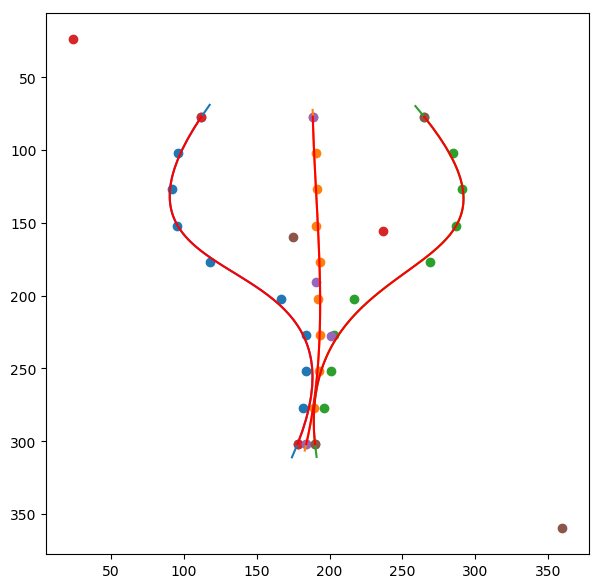

In [17]:
import numpy as np
data =np.array([[[112. ,  77. ],
        [188.5,  77. ],
        [265. ,  77. ]],

       [[ 96. , 102. ],
        [190.5, 102. ],
        [285. , 102. ]],

       [[ 92. , 127. ],
        [191.5, 127. ],
        [291. , 127. ]],

       [[ 95. , 152. ],
        [191. , 152. ],
        [287. , 152. ]],

       [[118. , 177. ],
        [193.5, 177. ],
        [269. , 177. ]],

       [[167. , 202. ],
        [192. , 202. ],
        [217. , 202. ]],

       [[184. , 227. ],
        [193.5, 227. ],
        [203. , 227. ]],

       [[184. , 252. ],
        [192.5, 252. ],
        [201. , 252. ]],

       [[182. , 277. ],
        [189. , 277. ],
        [196. , 277. ]],

       [[178. , 302. ],
        [184. , 302. ],
        [190. , 302. ]]])

fitBezierAndDraw(data,mode=2)

diffpara 0.06887578219175344
diffpara 0.03999997675418854
diffpara 0.03999997675418854
diffpara 0.020000040531158447
diffpara 0.029999971389770508
diffpara 0.03000001609325409
diffpara 0.029999978840351105
diffpara 0.009999990463256836
diffpara 0.024306811392307337
diffpara 0.0
diffpara 0.07640102505683904
diffpara 0.04999997466802597
diffpara 0.019999980926513672
diffpara 0.04999995231628418
diffpara 0.019999980926513672
diffpara 0.030000045895576477
diffpara 0.010000050067901611
diffpara 0.0299999862909317
diffpara 0.019999980926513672
diffpara 0.030000001192092896
diffpara 0.009999990463256836


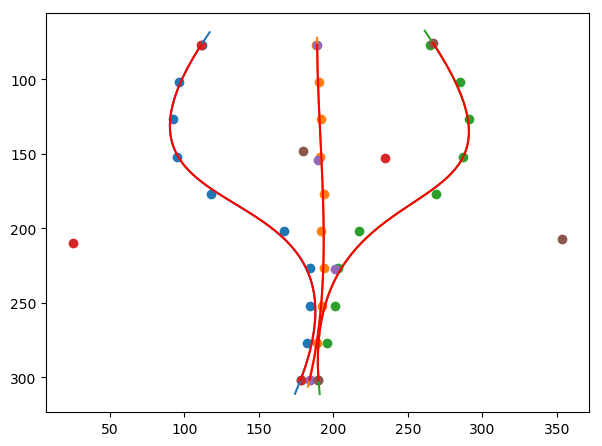

In [19]:
fitBezierAndDraw(data,mode=3)

diffpara 0.07887578196823597
diffpara 0.029999971389770508
diffpara 0.019999980926513672
diffpara 0.0299999862909317
diffpara 0.019999995827674866
diffpara 0.01000000536441803
diffpara 0.020000040531158447
diffpara 0.019999980926513672
diffpara 0.0
diffpara 0.024306811392307337
diffpara 0.0
diffpara 0.08640101552009588
diffpara 0.039999984204769135
diffpara 0.029999971389770508
diffpara 0.019999980926513672
diffpara 0.0299999862909317
diffpara 0.0299999862909317
diffpara 0.02000001072883606
diffpara 0.010000050067901611
diffpara 0.01000000536441803
diffpara 0.010000050067901611
diffpara 0.019999980926513672
diffpara 0.009999990463256836


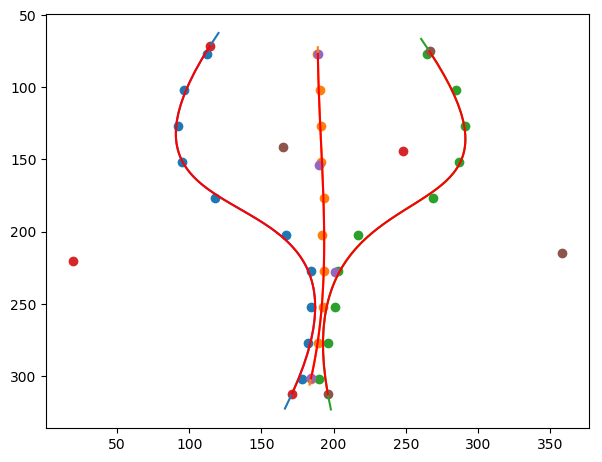

In [5]:
fitBezierAndDraw(data,mode=4)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math
import pandas as pd
import os

# この関数は画像の入った複数のフォルダが１つのフォルダに入っていることを前提としている。
#  指定フォルダ直下の画像ファイルは無視する。直下のフォルダの中しか見ず、さらにサブフォルダがあっても再帰的に探すようなことはしない。

def listimage(path='シルエット', needThum=False):

    directory = os.listdir(path)
    
    # まずフォルダを全部リストアップ　→ folders
    folders = []
    for x in os.listdir(path):  
        if os.path.isdir(path + '/'+x) and x[0] != '.' and x[0] !='_':  #パスに取り出したオブジェクトを足してフルパスに
            folders.append(path + '/'+x)
    # print(folders)

    # folders の各フォルダの中にある jpg ファイルをリストアップ → ffiles
    # ffiles はフォルダごとのリストのリスト
    ffiles = []
    for x in folders:
        files = []
        for f in os.listdir(x):
            entry = x + '/'+f
            if os.path.isfile(entry) and f[-4:]=='.jpg' and f[0] != '.':
                files.append(entry)
        ffiles.append(files)
    
    if needThum: # サムネイルの作成
        i = 0
        for cat in ffiles:
            # print(folders[i])
            sam = Image.new('RGB', (800,600),(0,0,0))
            row = col = 0
            for rad in cat:
                img = Image.open(rad, 'r')
                thumbnail_size = (100, 100)
                img.thumbnail(thumbnail_size)
                sam.paste(img,(col,row))
                col += 100
                if col == 800:
                    col = 0
                    row += 100
                # plt.imshow(sam)
            sam.save('{}THUM.png'.format(folders[i]), 'PNG')
            print("saved {}".format(folders[i]))
            i +=1

    return folders,ffiles

# ２枚の画像をサイズを並べた画像を作成する
def mkparaimage(img1,img2):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    if img1.ndim == 2:
        img11 = np.zeros((h1,w1,3))
        img11[:,:,0]=img11[:,:,1]=img11[:,:,2]=img1
    else:
        img11=img1
    if img2.ndim == 2:
        img22 = np.zeros((h2,w2,3))
        img22[:,:,0]=img22[:,:,1]=img22[:,:,2]=img2
    else:
        img22=img2
    paraimg = 255*np.ones((max(h1,h2),w1+w2+10,3),dtype=np.uint8)
    
    paraimg[0:h1,0:w1,:] = img11
    paraimg[0:h2,w1+10:,:]=img22
    
    return paraimg

# mkparaimage で２枚並べた画像を表示
def imshowpara(img1,img2):
    plotimg(mkparaimage(img1,img2))

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

# 処理結果画像（fimg)に処理前画像（bimg)の輪郭を描く
def draw2(bimg,fimg):
    if len(bimg.shape)==3:
        bimg2 = cv2.cvtColor(bimg,cv2.COLOR_BGR2GRAY)
    else:
        bimg2 = bimg.copy()
    if len(fimg.shape)==3:
        fimg2 = fimg.copy()
    else:
        fimg2 = cv2.cvtColor(fimg,cv2.COLOR_GRAY2BGR)
    # 処理前画像の輪郭
    # canvas = np.zeros_like(fimg2)
    canvas = fimg2.copy()
    _ret,bwimg = cv2.threshold(bimg2,128,255,cv2.THRESH_BINARY) # 白画素は255にする
    _img,cnt,hierarchy = cv2.findContours(bwimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # canvas = cv2.drawContours(canvas, cnt, -1, (255,230,230), thickness=-1)
    canvas = cv2.drawContours(canvas, cnt, -1, (255,0,200), thickness=1)
    # return cv2.addWeighted(fimg2, 0.5, canvas, 0.5,0)
    return canvas[:,:,::-1] # opencv -> PIL

# (x1,y1)から（x2,y2) に向かう直線のX軸に対する角度
def getDegreeOfALine(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        if dx == 0:
            deg = 90
        elif dx >0:
            deg = 180.0*np.arctan(dy/dx)/np.pi
        else:
            deg = 180*(1+np.arctan(dy/dx)/np.pi)
        return deg

# (x1,y1)から（x2,y2) に向かう直線の延長上の十分離れた２点の座標
def getTerminalPsOnLine(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        s1 = int(x1 + 1000*dx)
        t1 = int(y1 + 1000*dy)
        s2 = int(x1 - 1000*dx)
        t2 = int(y1 - 1000*dy)
        return s1,t1,s2,t2


# 重心と先端を結ぶ方向で方向を正規化

In [21]:
from skimage.morphology import skeletonize, skeletonize_3d
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage import io
import skimage.data
import skimage.color
import os
import numpy as np
import cv2

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

# 処理結果画像（fimg)に処理前画像（bimg)の輪郭を描く
def draw2(bimg,fimg):
    if len(bimg.shape)==3:
        bimg2 = cv2.cvtColor(bimg,cv2.COLOR_BGR2GRAY)
    else:
        bimg2 = bimg.copy()
    if len(fimg.shape)==3:
        fimg2 = fimg.copy()
    else:
        fimg2 = cv2.cvtColor(fimg,cv2.COLOR_GRAY2BGR)
    # 処理前画像の輪郭
    # canvas = np.zeros_like(fimg2)
    canvas = fimg2.copy()
    _ret,bwimg = cv2.threshold(bimg2,128,255,cv2.THRESH_BINARY) # 白画素は255にする
    _img,cnt,hierarchy = cv2.findContours(bwimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # canvas = cv2.drawContours(canvas, cnt, -1, (255,230,230), thickness=-1)
    canvas = cv2.drawContours(canvas, cnt, -1, (255,0,200), thickness=1)
    # return cv2.addWeighted(fimg2, 0.5, canvas, 0.5,0)
    return canvas[:,:,::-1] # opencv -> PIL

# (x1,y1)から（x2,y2) に向かう直線のX軸に対する角度
def getDegreeOfALine(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        if dx == 0:
            deg = 90
        elif dx >0:
            deg = 180.0*np.arctan(dy/dx)/np.pi
        else:
            deg = 180*(1+np.arctan(dy/dx)/np.pi)
        return deg

# (x1,y1)から（x2,y2) に向かう直線の延長上の十分離れた２点の座標
def getTerminalPsOnLine(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        s1 = int(x1 + 1000*dx)
        t1 = int(y1 + 1000*dy)
        s2 = int(x1 - 1000*dx)
        t2 = int(y1 - 1000*dy)
        return s1,t1,s2,t2

# マージンをつける
def makemargin(img,mr=2):
    h,w = img.shape[:2]
    w2 = mr*w
    h2 = mr*h
    x1 = int((w2-w)/2)
    y1 = int((h2-h)/2)
    img2 = np.zeros((h2,w2),np.uint8)
    img2[y1:y1+h,x1:x1+w] = img
    return img2

In [2]:
# ガウスぼかし、膨張収縮、輪郭近似で形状を整える。

# 十分ぼかす
CONTOURS_APPROX = 0.005 # 輪郭近似精度
HARRIS_PARA = 1.0 # ハリスコーナー検出で、コーナーとみなすコーナーらしさの指標  1.0 なら最大値のみ
CONTOURS_APPROX = 0.0002 # 輪郭近似精度
SHRINK = 0.8 # 0.75 # 収縮膨張で形状を整える時のパラメータ
GAUSSIAN_RATE2 = 0.1 # ガウスぼかしをかける程度

def RDreform(img,ksize=5,shrink=SHRINK):
    # ガウスぼかしを適用してシルエットを滑らかにする
    img2 = cv2.GaussianBlur(img,(ksize,ksize),0) # ガウスぼかしを適用
    _ret,img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY) # ２値化
    # 収縮・膨張によりヒゲ根を除去する
    area0 = np.sum(img2) # img2 の画素数*255 になるはず
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(ksize,ksize)) # 円形カーネル
    tmpimg = cv2.erode(img2,kernel,iterations = 1) # 収縮１回目
    area1 = np.sum(tmpimg) # 収縮したので area0 より少なくなる
    n = 1
    while area1  > shrink*area0: # 面積が SHRINK倍以下になるまで繰り返す
        tmpimg = cv2.erode(tmpimg,kernel,iterations = 1)
        area1 = np.sum(tmpimg) 
        n += 1
    # print("収縮・膨張回数",n)
    img3 = cv2.dilate(tmpimg,kernel,iterations = n) # 同じ回数膨張させる
    # あらためて輪郭を求め直す
    # まず最大の領域を取り出す
    _lnum, labelimg, cnt, _goc =cv2.connectedComponentsWithStats(img3)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    img3 = np.zeros_like(img3)
    img3[labelimg==areamax]=255
    _img,cnt,hierarchy = cv2.findContours(img3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    outimg = np.zeros_like(img3)
    # outimg = cv2.drawContours(outimg, cnt, 0, 255, thickness=-1) 
    # 近似輪郭を求めて描きなおす
    # area = cv2.contourArea(cnt[0]) # 面積
    perimeter = cv2.arcLength(cnt[0],True) # 周囲長
    epsilon = CONTOURS_APPROX*perimeter # 周囲長をもとに精度パラメータを決定
    approx = cv2.approxPolyDP(cnt[0],epsilon,True)
    outimg = cv2.drawContours(outimg, [approx], 0, 255, thickness=-1) 
    # 次の２行は領域が１つになっているかどうかの確認用
    nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(outimg)
    # print("NL",nLabels)
    return outimg

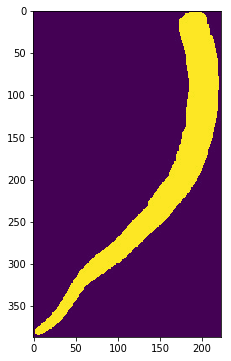

In [22]:
# src = cv2.imread('シルエット/17Apically/17daruma6o06_l.jpg')
# src = cv2.imread('シルエット/17Tran_ellip/17karami2o03_l.jpg')
# src = cv2.imread('シルエット/17Horn/17aomida1o02_l.jpg')
# src = cv2.imread('シルエット/17Tran_ellip/17heians1o07_l.jpg')
# path='シルエット/17Horn/17aomida1o02_l.jpg'
# path='シルエット/17Spheric/17yakumi2o06_l.jpg'
path ='シルエット/17Horn/17aomida1o02_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
fig = plt.figure(figsize=(8,6),dpi=72)
plt.imshow(src)

In [23]:
GAUSSIAN_RATE = 0.25 # ガウスぼかしをかける量

# シルエットを滑らかにし、重心と先端の位置を返す関数
def getGoCandTip(src, showResult=False, useOldImage=True):
    # useOldImage = True なら元の画像を使って結果を表示、Falseなら滑らかにした画像
    img = makemargin(src) # 作業用のマージンを確保
    img2 = img.copy() # 加工前の状態を保存
    # ガウスぼかしを適用してシルエットを滑らかにする
    ksize = int(GAUSSIAN_RATE*img.shape[1]/2)*2+1 # ぼかし量  元の図形の幅に応じて決める
    img = cv2.GaussianBlur(img,(ksize,ksize),0) # ガウスぼかしを適用
    # ２値化してシルエットを求め直す
    _ret,img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # ２値化
    # Harris コーナ検出
    himg = np.float32(img)
    himg = cv2.cornerHarris(himg,blockSize=3,ksize=3,k=0.04)
    # コーナー度合いが最大の領域を求める
    wimg = np.zeros_like(img)
    wimg[himg>=HARRIS_PARA*himg.max()]=255 # コーナー度最大値の領域を２５５で塗りつぶす。
    # 最大値に等しい値の領域が１点とは限らないし、いくつかの点の塊になるかもしれない
    _lnum, _img, cnt, goc = cv2.connectedComponentsWithStats(wimg)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    t_x,t_y = np.round(goc[areamax]) # 重心の位置

    # コア全体の重心の位置を求める
    _lnum, _img, _cnt, goc = cv2.connectedComponentsWithStats(img)
    c_x,c_y = np.round(goc[1])

    # コーナーの場所のマーキング（デバッグ用）
    # himg = cv2.dilate(himg,None,iterations = 3)
    # img3[himg>=HARRIS_PARA*himg.max()]=[0,0,255]

    if showResult: # 
        if useOldImage:
            img3 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
        else:
            img3 = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
        plt.figure(figsize=(10,7),dpi=75)
        img3=cv2.circle(img3,(int(t_x),int(t_y)),5,(0,255,0),2)
        img3=cv2.circle(img3,(int(c_x),int(c_y)),5,(255,255,0),2)
        x1,y1,x2,y2= getTerminalPsOnLine(c_x,c_y,t_x,t_y)
        img3=cv2.line(img3,(x1,y1),(x2,y2),(255,0,255),2)                 
        img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)
        plt.subplot(122), plt.imshow(img3)
        plt.show()
        
    # 結果を返す (c_x,c_y) 重心　　(t_x,t_y)  先端の位置 img2 滑らかになったシルエット画像
    return c_x,c_y,t_x,t_y

In [24]:
# 回転した上でマージンをカットした画像を返す
def roteteAndCutMargin(img,deg,c_x,c_y):
    # 非常に稀であるが、回転すると全体が描画領域外に出ることがあるので作業領域を広く確保
    # mat = cv2.getRotationMatrix2D((x0,y0), deg, 1.0) # アフィン変換マトリクス
    bigimg = makemargin(img,mr=2) # 作業用のマージンを確保
    h3,w3 = img.shape[:2]
    h4,w4 = bigimg.shape[:2]
    mat = cv2.getRotationMatrix2D((c_x+(w4-w3)/2,c_y+(h4-h3)/2), deg-90, 1.0) # アフィン変換マトリクス

    # アフィン変換の適用
    bigimg = cv2.warpAffine(bigimg, mat, (0,0),1)

    # 再び最小矩形を求めて切り出す。ただし、マージンを５つける
    _nLabels, _labelImages, data, _center = cv2.connectedComponentsWithStats(bigimg) 
    resultimg = bigimg[data[1][1]-5:data[1][1]+data[1][3]+5,data[1][0]-5:data[1][0]+data[1][2]+5]

    return resultimg

In [25]:
# シルエット画像の標準化
# 画像サイズをある程度揃えたい

UNIT = 256 # 長い方の辺をこのサイズになるよう拡大縮小する

def getstandardShape(src, unitSize=UNIT,showResult=False):
    # 重心と先端の位置を調べる
    c_x,c_y,t_x,t_y = getGoCandTip(src,showResult=False)
    deg = getDegreeOfALine(c_x,c_y,t_x,t_y)
    # 重心と先端を結ぶラインがY軸となるように回転し余白はカット
    img = roteteAndCutMargin(src,deg,c_x,c_y)
   
    # 大きさを標準化したいが、無駄に根が長いと相対的に重要部分が小さくなるのでまず根を削る
    # 作業用のマージンを確保
    img5 = makemargin(img) 
    if showResult: refimg = img5.copy() # 確認用元画像
    # 少し形を整えておく RDreform は上の方で定義してある
    img5 = RDreform(img5)

    # 最大面積の領域を抜き出す。ゴミ領域があるかもしれないので念のため。
    _nLabels, labelImages, data, _center = cv2.connectedComponentsWithStats(img5)
    img5 = img5[data[1][1]:data[1][1]+data[1][3],data[1][0]:data[1][0]+data[1][2]]
    if showResult: refimg = refimg[data[1][1]:,data[1][0]:data[1][0]+data[1][2]]

    # 長辺が UNIT ピクセルになるよう縮小し、(1.5xUNIT)x(1.5xUNIT)の画像の中央に配置する。
    h,w = img5.shape[:2]
    s_r = UNIT/w if w > h else UNIT/h #  縮小率    
    rsh,rsw = int(s_r*h),int(s_r*w) # リサイズ後のサイズ
    x0 = int((1.5*UNIT-rsw)/2) # はめ込みの基準点
    y0 = int((1.5*UNIT-rsh)/2)
    canvas = np.zeros((int(1.5*UNIT),int(1.5*UNIT)),np.uint8) # キャンバスの確保
    canvas[y0:y0+rsh,x0:x0+rsw] = cv2.resize(img5,(rsw,rsh)) # リサイズして中央にはめ込み

    # 確認用画像も同じリサイズを適用　確認用の場合は尻尾の部分を残して表示したいので少し面倒
    if showResult: 
        refimg2 = np.zeros((int(1.5*UNIT),int(1.5*UNIT)),np.uint8)
        refimg = cv2.resize(refimg,(rsw,int(s_r*refimg.shape[0])))
        if int(1.5*UNIT) - y0 > refimg.shape[0]:
            refimg2[y0:y0+refimg.shape[0],x0:x0+rsw] = refimg
        else:
            refimg2[y0:int(1.5*UNIT),x0:x0+rsw] = refimg[0:int(1.5*UNIT)-y0,:]
            
    # 最後にもう一度だけガウスぼかしを適用してシルエットを滑らかにする
    ksize = 2*int((GAUSSIAN_RATE2*UNIT)/2)+1 # ぼかし量  元の図形の幅に応じて決める
    canvas = cv2.GaussianBlur(canvas,(ksize,ksize),0) # ガウスぼかしを適用
    _ret,resultimg = cv2.threshold(canvas, 128, 255, cv2.THRESH_BINARY) # ２値化

    if showResult:
        plt.figure(figsize=(6,6),dpi=200)
        plt.imshow(draw2(refimg2,resultimg))
        
    return resultimg

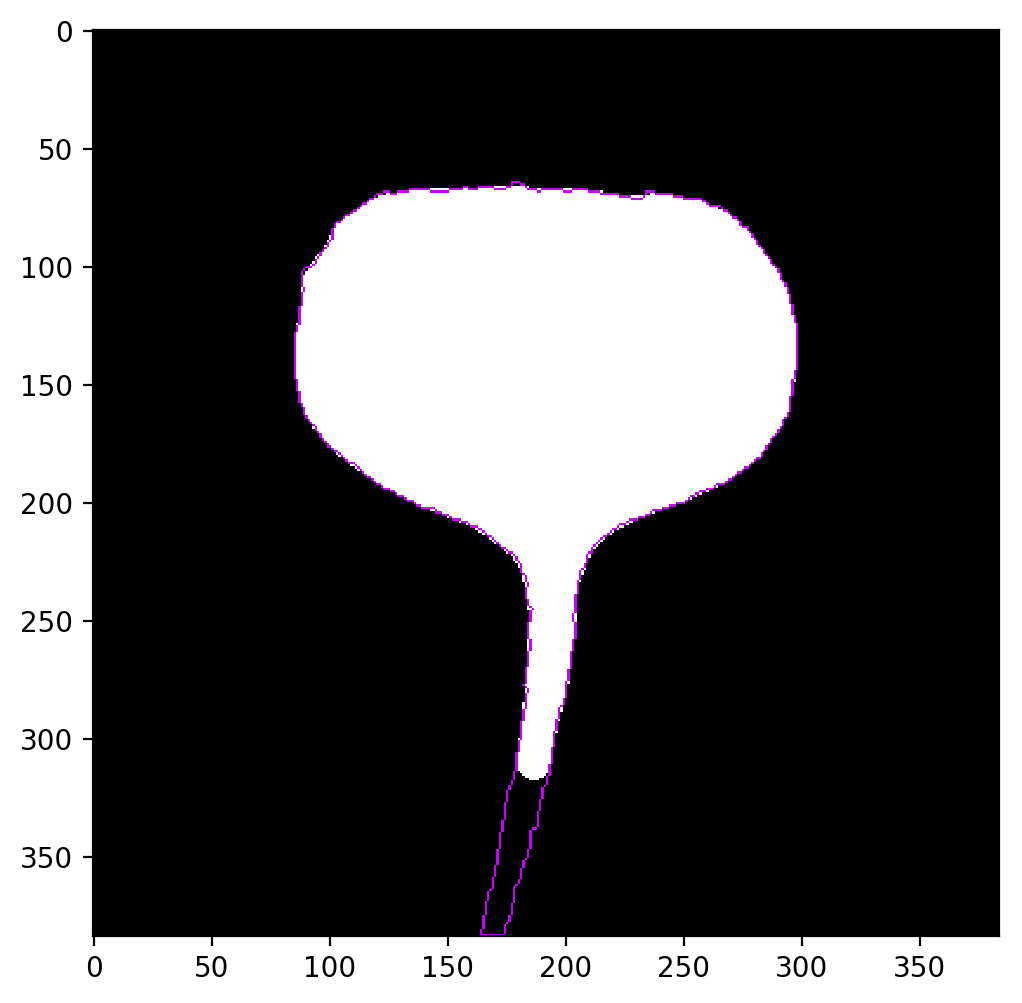

In [39]:
path ='シルエット/17Tran_ellip/17karami2o03_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img4 = getstandardShape(src,showResult=True)

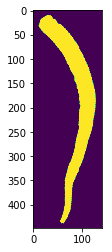

In [37]:
path ='シルエット/17Horn/17aomida1o02_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
c_x,c_y,t_x,t_y = getGoCandTip(src,showResult=False)
deg = getDegreeOfALine(c_x,c_y,t_x,t_y)
img4 = roteteAndCutMargin(src,deg,c_x,c_y)
plt.imshow(img4);

[array([[[163,  66]],

       [[162,  67]],

       [[161,  67]],

       ...,

       [[166,  66]],

       [[165,  66]],

       [[164,  66]]], dtype=int32)]


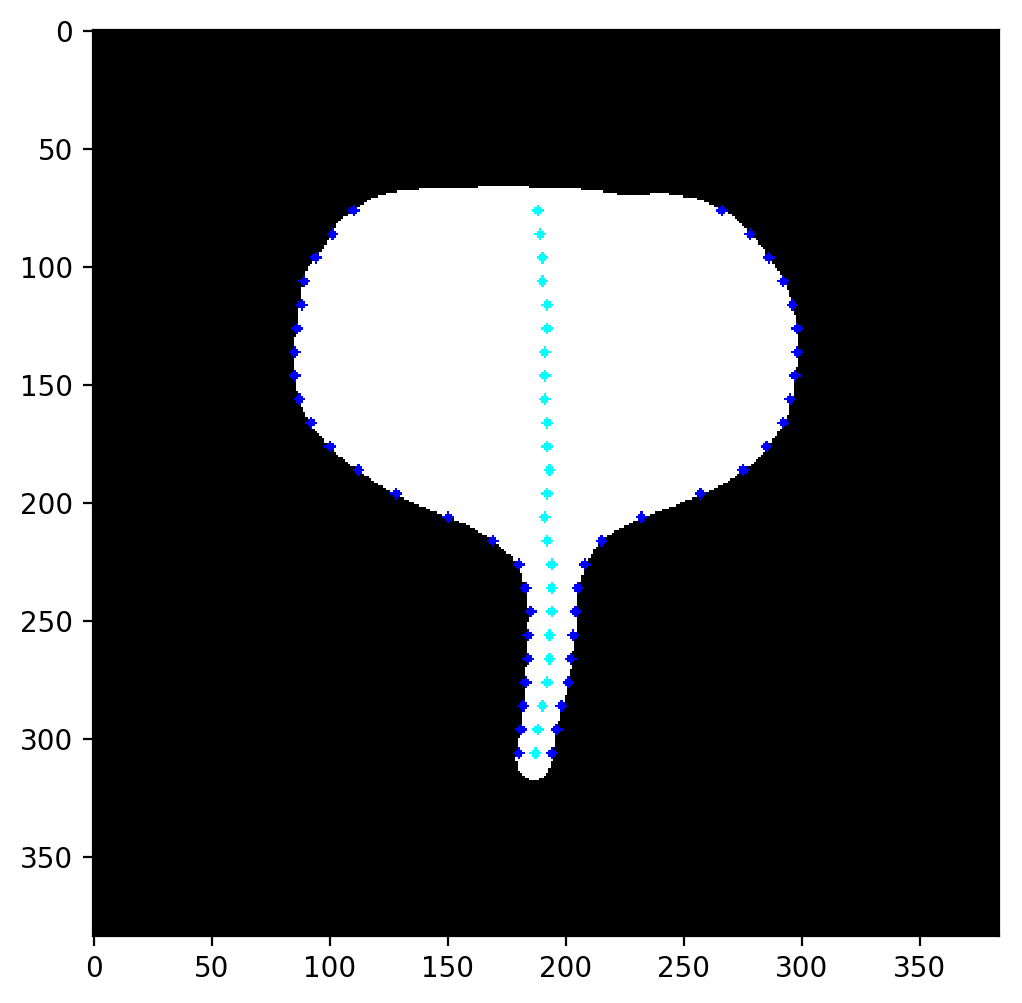

In [43]:
_img,cnt,hierarchy = cv2.findContours(img4, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
x0,y0,w,h = cv2.boundingRect(cnt[0])
x = cnt[0][:,0][:,0]
y = cnt[0][:,0][:,1]

print(cnt)
data = []
for i in range(y0+10,y0+h-10,10):
    xs = x[y==i]
    xl = min(xs)
    xr = max(xs)
    xc = (xl+xr)/2
    data.append([[xl,i],[xc,i],[xr,i]])
test = cv2.cvtColor(img4,cv2.COLOR_GRAY2BGR)
for p in data:
    cv2.circle(test,(int(p[0][0]),int(p[2][1])),2,(255,0,0),-1)
    cv2.circle(test,(int(p[1][0]),int(p[2][1])),2,(255,255,0),-1)
    cv2.circle(test,(int(p[2][0]),int(p[2][1])),2,(255,0,0),-1)
plt.figure(figsize=(6,6),dpi=200)
plt.imshow(test[:,:,::-1])

npdata = np.array(data)

In [29]:
def getBezierDraw(data,mode=2, showresult = True, img=None):
    datal,datac,datar = data[:,0],data[:,1],data[:,2]
    # 初期の推定パラメータの決定
    cpxl,cpyl,bezXl,bezYl = fitBezierCurve3(points=datal,precPara=0.01,mode=mode)
    cpxc,cpyc,bezXc,bezYc = fitBezierCurve3(points=datac,precPara=0.01,mode=mode)
    cpxr,cpyr,bezXr,bezYr = fitBezierCurve3(points=datar,precPara=0.01,mode=mode)
    
    test = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    for p in data:
        cv2.circle(test,(int(p[0][0]),int(p[1][1])),2,(255,0,0),-1)
        cv2.circle(test,(int(p[1][0]),int(p[1][1])),2,(255,255,0),-1)
        cv2.circle(test,(int(p[2][0]),int(p[2][1])),2,(255,0,0),-1)
    res = [[cpxl,cpyl,bezXl,bezYl],[cpxc,cpyc,bezXc,bezYc],[cpxr,cpyr,bezXr,bezYr]]
    for cpx,cpy,bezX,bezY in res:
        for i in range(len(cpx)):
            cv2.circle(test,(int(cpx[i]),int(cpy[i])),3,(255,23,127),1)
        tplins = np.linspace(-0.02, 1.02,50)
        for i in range(49):
            p1x = bezX.subs(t,tplins[i])
            p1y = bezY.subs(t,tplins[i])
            p2x = bezX.subs(t,tplins[i+1])
            p2y = bezY.subs(t,tplins[i+1])
            cv2.line(test,(p1x,p1y),(p2x,p2y),(255,0,0),1)
    #cv2.imshow("result",test)
    #cv2.waitKey(0)
    #cv2.destroyAllWindow()
    #cv2.waitKey(1)
    plt.imshow(test[:,:,::-1])

In [ ]:
getBezierDraw(npdata,mode=2, showresult = True, img=img4)

diffpara 0.19059190340340143
diffpara 0.10000004991889
diffpara 0.0899999588727951
diffpara 0.06999996304512024
diffpara 0.03999997675418854
diffpara 0.060000017285346985
diffpara 0.06999995559453964
diffpara 0.039999984204769135
diffpara 0.0599999874830246
diffpara 0.010000050067901611
diffpara 0.0
diffpara 0.05834419652819639
diffpara 0.0
diffpara 0.238037969917059
diffpara 0.08999999612569809
diffpara 0.059999966993927956
diffpara 0.08000007271766663
diffpara 0.06999998912215233
diffpara 0.019999980926513672
diffpara 0.029999971389770508
diffpara 0.04999997466802597
diffpara 0.050000011920928955
diffpara 0.040000028908252716
diffpara 0.039999961853027344
diffpara 0.03000006079673767
diffpara 0.009999990463256836


In [ ]:
fitBezierAndDraw(npdata,mode=4)

In [34]:
npdata

array([], dtype=float64)